# Importing Libraries

In [2]:
#Importing required Libraries

import theano
import theano.tensor as T
from theano.tensor import _shared
import os
os.environ['KERAS_BACKEND'] = 'theano'
import numpy as np 
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from keras_contrib.losses import DSSIMObjective 
from keras import backend as K
from keras import layers
from keras.layers import Input,Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform

Using Theano backend.


# Preparing to Load Data

In [8]:
#Creating a list of names of input_training data for training 

id_name1 = 'data/input_training_'
id_name2 = '00_'
id_name3 = '99.npy'
train_names_inputs=[]
for i in range(0,51):
    if i<10:
        value='0'+str(i)
    else:
        value=str(i)
    input_data_name = id_name1+value+id_name2+value+id_name3
    train_names_inputs.append(input_data_name)

In [9]:
#Creating a list of names of input_training data for validation

id_name1 = 'data/input_training_'
id_name2 = '00_'
id_name3 = '99.npy'

val_names_inputs=[]
for i in range(51,53):
    if i<10:
        value='0'+str(i)
    else:
        value=str(i)
    input_data_name = id_name1+value+id_name2+value+id_name3
    val_names_inputs.append(input_data_name)
    
val_names_inputs.append('data/input_training_5300_5342.npy')

In [10]:
#Creating a list of names of label_training data for training

id_name1 = 'data/label_training_'
id_name2 = '00_'
id_name3 = '99.npy'
train_names_labels=[]
for i in range(0,51):
    if i<10:
        value='0'+str(i)
    else:
        value=str(i)
    input_data_name = id_name1+value+id_name2+value+id_name3
    train_names_labels.append(input_data_name)

In [11]:
#Creating a list of names of label_training for validation

id_name1 = 'data/label_training_'
id_name2 = '00_'
id_name3 = '99.npy'

val_names_labels=[]
for i in range(51,53):
    if i<10:
        value='0'+str(i)
    else:
        value=str(i)
    input_data_name = id_name1+value+id_name2+value+id_name3
    val_names_labels.append(input_data_name)
    
val_names_labels.append('data/label_training_5300_5342.npy')

In [12]:
#A dictionary to store names of train and validation files for input and label

partition={}
partition['train_input']=train_names_inputs
partition['val_input']=val_names_inputs
partition['train_label']=train_names_labels
partition['val_label']=val_names_labels

In [8]:
def standardize(X):         # A Function to normalize the dataset for better training results.      
    newX = (X-np.mean(X))/(np.std(X))
    return(newX)


def load_data(input_name,label_name):  #A Function to load data, reshape it by transpose and apply normalization
    
    x = np.load(input_name)
    y = np.load(label_name)
    
    xt = np.transpose(x, (0,2,3,1)) 
    yt = np.transpose(y, (0,2,3,1))
    
    xts=standardize(xt)
    yts=standardize(yt)
        
    return(xts,yts)

# Score Functions

In [4]:
def meanDifferenceCalculation(img1, img2):     #To calculate mean difference of images
    img1_mean = T.mean(img1)
    img2_mean = T.mean(img2)
    return(T.abs_(img1_mean - img2_mean))

def minDifferenceCalculation(img1, img2):    #To calculate min difference of images
    img1_min = T.min(img1)
    img2_min = T.min(img2)
    return(T.abs_(img1_min - img2_min))

def maxDifferenceCalculation(img1, img2):     #To calculate max difference of images
    img1_max = T.max(img1)
    img2_max = T.max(img2)
    return(T.abs_(img1_max - img2_max))

def scoreCalculation(img1_T, img2_T):        #To calculate the combined score Fuction
    
    #DSSIMObjective is a loss fuction from keras_contrib module. 
    loss_func = DSSIMObjective(kernel_size=4)     #kernel_size should be a factor of image_pixel ie. 4 is factor of 256
    dssim = loss_func(img1_T,img2_T)              #Calculating the loss.
    
    ssim = 1-(2*dssim)    #Getting ssim from dssim value                       
    
    #mean squared error
    mse = T.mean(T.sqr(img1_T-img2_T))
    
    #mean,min,max
    meanDifference = meanDifferenceCalculation(img1_T, img2_T)
    minDifference = minDifferenceCalculation(img1_T, img2_T)
    maxDifference = maxDifferenceCalculation(img1_T, img2_T)
    
    #Score function
    score = (2 - 2 * ssim) + mse + meanDifference + minDifference + maxDifference

    return(score)

# CONVNET ARCHITECTURE

In [15]:
def MODEL(input_shape=(256,256,15)):   #Convolutional Neural Network Architechture
    
    input_X=Input(input_shape)
    X = Conv2D(16, (3, 3), strides = (1, 1),padding='same', name = 'conv1', kernel_initializer = glorot_uniform(seed=1))(input_X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = Conv2D(1, (3, 3), strides = (1, 1),padding='same', name = 'conv2', kernel_initializer = glorot_uniform(seed=1))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    model = Model (inputs = input_X , outputs= X, name= 'Simple_Sr')
    
    return(model)
    

In [16]:
model = MODEL(input_shape = (256, 256, 15))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 15)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 16)      2176      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 256, 256, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 256, 256, 1)       145       
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 256, 256, 1)       4         
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 1)       0         
Total para

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[scoreCalculation])

In [ ]:
%%time
hist1 = []
hist_val = []
for epoch in range(7):                                   #Loop for running epochs (Here:I trained for 7 epochs)
    print('EPOCH NUMBER:',epoch+1)
    for i in range(len(partition['train_input'])):        #Training each file at a time
        x,y = load_data(partition['train_input'][i],partition['train_label'][i])
        hist = model.fit(x, y, epochs=1, batch_size=16)
        hist1.append(hist.history)
        
    
    for i in range(len(partition['val_input'])):         #Validation of last 3 files
        x,y = load_data(partition['val_input'][i],partition['val_label'][i])
        hist = model.evaluate(x, y)
        hist_val.append(hist)
        

#with open('history_epoch_7', 'wb') as f:        #For saving training history
#    pickle.dump(hist1, f)
#with open('history_val', 'wb') as f:            #For saving validation history
#    pickle.dump(hist_val, f)
#model.save('Model_epoch_7.h5')                 #For saving the model

# Plotting Train and Validation (score and loss)

In [18]:
#with open('history_epoch_7', 'rb') as f:   #Presaved train history
#    hist1 = pickle.load(f)

#with open('history_val','rb') as f:        #Presaved validation history
#    hist_val = pickle.load(f)

In [19]:
# Extracting Loss and Score from saved history of loss and score.

loss=[]
score=[]
for dic in hist1:               
    loss.append(dic['loss'])
    score.append(dic['scoreCalculation'])

In [20]:
#Averaging up score/loss to give score/loss for 1 epoch as training score is for each file individually.

train_score=[]
train_loss=[]
for i in range(int(len(score)/51)):        #In simple words i=0 to 6 for 7 epochs. As 357/51 = 7 epochs where 357 = len(score)
    single_epoch=score[i*51:(i+1)*51]      #Extracting batch of 51 score for each epoch of 51 files
    train_score.append(np.mean(single_epoch))  #Appending mean of 51 scores(1 epoch) to train_score
    
    single_epoch_loss=loss[i*51:(i+1)*51]     #Doing same for loss
    train_loss.append(np.mean(single_epoch_loss)) #Appending mean for loss

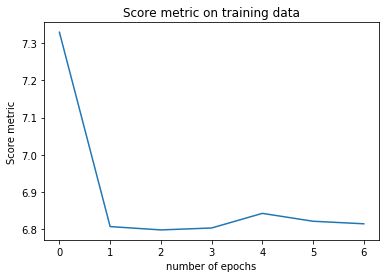

In [64]:
plt.plot(train_score)
plt.xlabel('number of epochs')
plt.ylabel('Score metric')
plt.title('Score metric on training data')
plt.savefig('train_score.jpg')

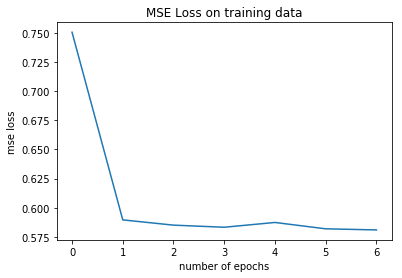

In [65]:
plt.plot(train_loss)
plt.xlabel('number of epochs')
plt.ylabel('mse loss')
plt.title('MSE Loss on training data')
plt.savefig('train_loss.jpg')

In [23]:
#Averaging up score/loss for validation data to give score/loss for each epoch

val_score=[]
val_loss=[]
for i in range(int(len(hist_val)/3)):       #In simple words i=0 to 6 for 7 epochs. As 21/3 = 7 epochs where 21 = len(hist_val) and 3=validation files
    val_score.append(np.mean(score[i*3:(i+1)*3])) #Extracting batch of 3 scores for each epoch of 3 validation files
    val_loss.append(np.mean(loss[i*3:(i+1)*3]))   #Doing same for loss

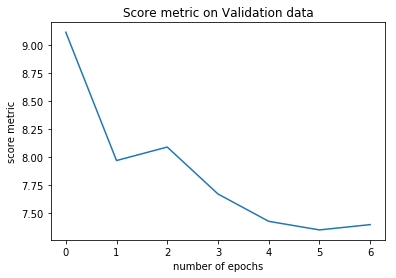

In [66]:
plt.plot(val_score)
plt.xlabel('number of epochs')
plt.ylabel('score metric')
plt.title('Score metric on Validation data')
plt.savefig('validation_score.jpg')

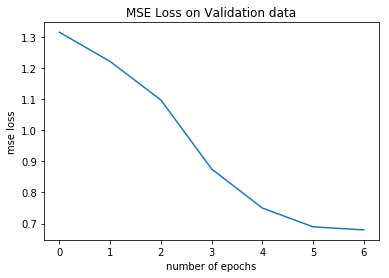

In [67]:
plt.plot(val_loss)
plt.xlabel('number of epochs')
plt.ylabel('mse loss')
plt.title('MSE Loss on Validation data')
plt.savefig('validation_loss.jpg')

# Individual Results with test data

In [5]:
#model = load_model('Model_epoch_7.h5', custom_objects={'scoreCalculation': scoreCalculation})  #Presaved model for num_epochs=7

In [6]:
input_test = 'data/input_test_set.npy'
label_test = 'data/label_test_set.npy'

In [9]:
x_test,y_test = load_data(input_test,label_test)

In [12]:
#with open('data/date.txt','r') as f:
#    date_text = f.read()
#date_text = date_text.split('\n')

In [19]:
date_train = 'data/date_training.npy'
date_test = 'data/date_test_set.npy'

train_date = np.load(date_train)
test_date = np.load(date_test)

In [20]:
test_history=[]
for i in range(len(x_test)):
    hist=model.evaluate(x_test[i].reshape((1,256,256,15)),y_test[i].reshape((1,256,256,1)))
    test_history.append(hist)

1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 267ms/step


In [21]:
test_loss=[]
test_score=[]
for i in test_history:
    test_loss.append(i[0])
    test_score.append(i[1])

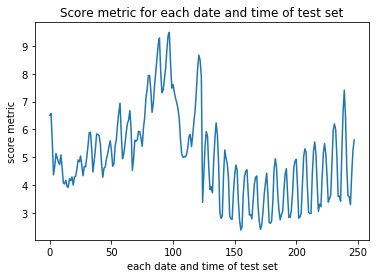

In [22]:
plt.plot(test_score)
plt.xlabel('each date and time of test set')
plt.ylabel('score metric')
plt.title('Score metric for each date and time of test set')
plt.savefig('test_score_for_each_record.jpg')

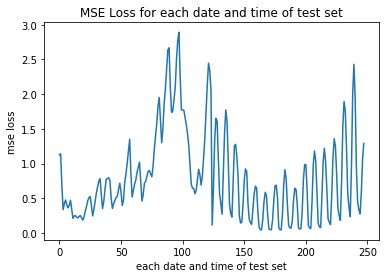

In [23]:
plt.plot(test_loss)
plt.xlabel('each date and time of test set')
plt.ylabel('mse loss')
plt.title('MSE Loss for each date and time of test set')
plt.savefig('test_loss_for_each_record.jpg')

In [24]:
test_results=pd.DataFrame()
test_results['DateTime']=[i.decode('ascii') for i in test_date]
test_results['loss']=test_loss
test_results['score']=test_score

# Average Results

In [25]:
test_results.describe()

,loss,score
count,248.000000,248.000000
mean,0.806500,5.001534
std,0.626931,1.545484
min,0.043003,2.385495
25%,0.346850,3.940689
50%,0.648364,4.857776
75%,1.062439,5.815931
max,2.892654,9.489738


It can be seen from test_results.describe() that mean of loss and score are as follows:

average_loss=0.806500

average_score=5.001534

In [18]:
test_results.head()

,DateTime,loss,score
0,2018011612,1.125401,6.509701
1,2018011615,1.139553,6.571133
2,2018011618,0.676640,5.577474
3,2018011621,0.336074,4.362339
4,2018011700,0.421846,4.661493


In [39]:
test_results.to_csv('test_results.csv',index=False)